# Beoordeling Tijdreeksmodellen
*Auteurs: O.N. Ebbens (Artesia)*

Een veelgestelde vraag is hoe je een geoptimaliseerd model moet beoordelen. Dit notebook laat zien welke methoden hiervoor gebruikt kunnen worden aan de hand van geselecteerde voorbeelden. Een geoptimaliseerd model komt met diverse statistieken. Aan de hand van een praktijkreeks wordt uitgelegd wat de getallen betekenen en hoe deze statistieken gebruikt kunnen worden.

Een veelgebruikt criterium voor modelbeoordeling is de ‘fit’, uitgedrukt in EVP. Ofwel: hoe goed lijkt de simulatie op de metingen. Het notebook laat zien in hoeverre deze ‘fit’ een goede indicatie is voor de voorspellende waarde van het model.

Het notebook behandelt de meest gebruikte toetsen. Speciale aandacht wordt besteed aan het kwantificeren van de betrouwbaarheid de parameters. Wat is er nodig om dit te kunnen doen en hoe kan je het model aanpassen doen, zodat je aan de voorwaarden voldoet. Naast statistische beoordeling is ook een fysische of visuele beoordeling mogelijk. 


%% 

IN DE OFFERTE STAAT DEZE TEKST, HEBBEN WE EEN VOORBEELD VAN ZO'N MODEL?

Er wordt een voorbeeld gegeven van reeksen die weliswaar statistisch goed beoordeeld worden, maar fysisch niet plausibel zijn. Er worden verschillende manieren besproken het model te toetsen op fysische plausibiliteit: 


LIJKT MIJ OOK NUTTIG OM EEN MODEL TE LATEN ZIEN DIE NIET DOOR ALLE TOETSEN HEENKOMT MAAR TOCH BEST GOED IS.

%%

### Inhoudsopgave

- [Tijdreeksmodel](#tijdreeksmodel)
- [Visuele beoordeling](#visueel)
- [Fit statistieken](#fit)
- [Model parameters](#parameters)
- [Model diagnostics](#diagnostics)
- [Fit report](#fitreport)

## Algemeen stappenplan

De volgende onderdelen geven informatie over de betrouwbaarheid van een tijdreeksmodel:
- visuele vergelijking gemeten en gemodelleerde tijdreeksen
- validatie tijdreeksmodel met extra metingen 
- fit statistieken
- betrouwbaarheid parameters
- correlatie parameters
- geheugen van de responsefuncties
- diagnostische toetsen

Voor het beoordelen van een tijdreeksmodel is het belangrijk om vast te stellen wat het doel van het tijdreeksmodel is. Op basis van dit doel kunnen de criteria voor bovenstaande onderdelen worden vastgesteld.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps
import datetime as dt

ps.set_log_level("ERROR")
#ps.show_versions()

## Tijdreeksmodel <a name="tijdreeksmodel"></a>

In dit notebook maken we gebruik van een simpel tijdreeksmodel met neerslag en verdamping als verklarende variabelen. 

In [2]:
# inlezen tijdreeksen
oseries = pd.read_csv("data/grondwaterstand.csv",
                       parse_dates=True,  squeeze=True, index_col=0)
neerslag = pd.read_csv("data/neerslag.csv", parse_dates=True,
                    squeeze=True, index_col=0)
verdamping = pd.read_csv("data/verdamping.csv", parse_dates=True,
                    squeeze=True, index_col=0)

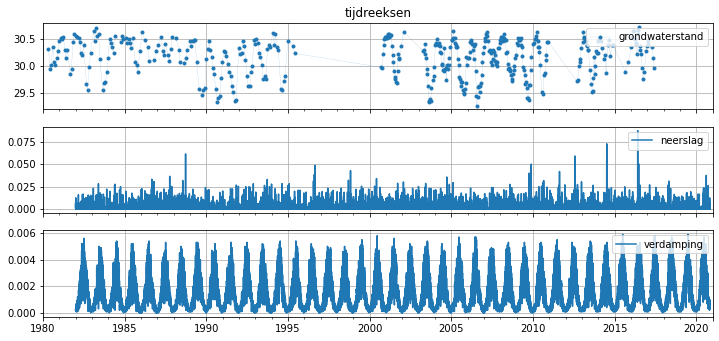

In [5]:
# laat de tijdreeksen zien in een figuur
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(12,6), sharex=True)
oseries.plot(ax=ax1, label='grondwaterstand', marker='.', lw=0.1, legend=True)
neerslag.plot(ax=ax2, label='neerslag')
verdamping.plot(ax=ax3, label='verdamping')
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(dt.datetime(1980,1,1), dt.datetime(2021,1,1))
    ax.legend(loc=1)
    ax.grid()
ax1.set_title('tijdreeksen');

%% OM EEN OF ANDERE REDEN KRIJG IK DE EERSTE KEER DAT IK HET MODEL WIL SOLVEN TELKENS EEN ERROR %%

In [7]:
# maken tijdreeksmodel
ml = ps.Model(oseries)
sm = ps.StressModel(neerslag-verdamping, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(sm)
ml.solve(tmin='1990', report=False)

## Visuele check <a name="visueel"></a>

De eerste check om de betrouwbaarheid van het model te bepalen is vaak een visuele vergelijking van de modelsimulatie met de metingen. Het makkelijkst is om hiervoor een grafiek te maken waarin beide worden getoond.

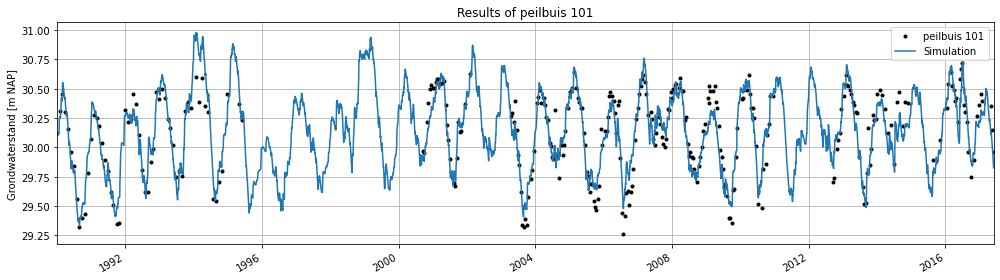

In [8]:
ax = ml.plot(figsize=(14,4))
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.grid()

### Validatie
Wanneer er voldoende metingen zijn kan ervoor worden gekozen om een validatie uit te voeren. Hierbij wordt de tijdreeks met gemeten grondwaterstanden gesplitst in een trainings- en een testperiode. Het model wordt gefit op de metingen in de trainingsperiode en er wordt een modelsimulatie gemaakt voor de testperiode. Het vergelijken van de gesimuleerde grondwaterstanden met de metingen in de testperiode geeft een goede indicatie hoe goed het model presteert.

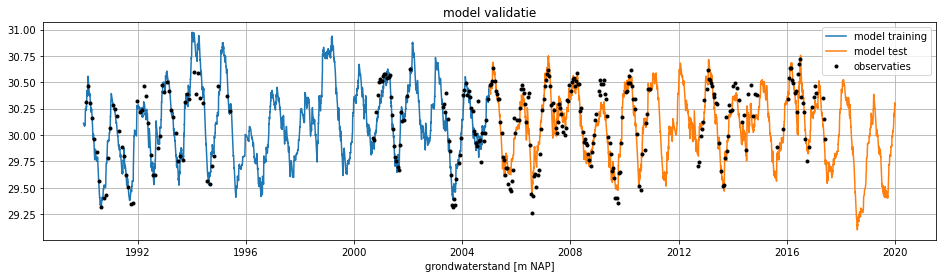

In [9]:
# train het model op periode 1990 - 2005, test het model op de periode 2005 - 2020
ml_train = ml.copy()
ml_train.solve(tmin='1990', tmax='2005', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train.simulate(tmin='1990', tmax='2005'), label='model training')
ax.plot(ml_train.simulate(tmin='2005', tmax='2020'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_xlabel('grondwaterstand [m NAP]');

De trainings- en testperiode kunnen zelf worden gekozen. De testperiode kan ook voor de trainingsperiode liggen, zie voorbeeld hieronder. Let er wel op dat er van de verklarende tijdreeksen, in dit geval neerslag en verdamping, metingen beschikbaar moeten zijn voor zowel de test- als de trainingsperiode.

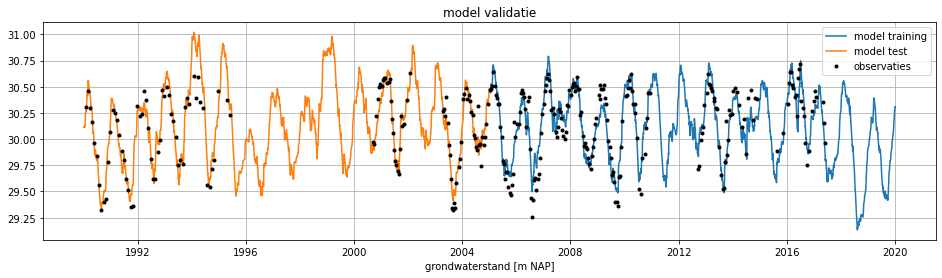

In [10]:
# train het model op periode 2005 - 2020, test het model op de periode 1990 - 2005
ml_train.solve(tmin='2005', tmax='2020', report=False)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(ml_train.simulate(tmin='2005', tmax='2020'), label='model training')
ax.plot(ml_train.simulate(tmin='1990', tmax='2005'), label='model test')
ax.plot(oseries['1990':], ls='', marker='.', label='observaties', color='k')
ax.legend()
ax.grid()
ax.set_title('model validatie')
ax.set_xlabel('grondwaterstand [m NAP]');

## Fit statistieken<a name="fit"></a>

Naast de visuele vergelijking van gemodelleerde en gemeten grondwaterstanden bestaan er ook verschillende statitische parameters die iets zeggen over de fit tussen gemodelleerde en gemeten grondwaterstanden. In `pastas` is het mogelijk om de volgende statistische parameters op te vragen via `ml.stats`:
- `mae`: Mean absolute error. Een waarde van 0 staat voor een optimale fit.
- `rmse`: Root mean squared error. Een waarde van 0 staat voor een optimale fit.
- `sse`: Sum of the squares of the error. Een waarde van 0 staat voor een optimale fit
- `evp`: Explained variance percentage. Een waarde van 100% staat voor een optimale fit. In de praktijk wordt een evp lager dan 60-80% vaak gebruikt om de modelresultaten niet verder te gebruiken. 
- `rsq`: $R^2$, r-squared of determinatiecoëfficiënt heeft een waarde van 1 bij een optimale fit.
- `nse`: Nash-Sutcliffe model efficiency coefficient. Een waarde van 1 staat voor een optimale fit.



In [11]:
# fit statistics kunnen worden opgevraagd met ml.stats.<naam>
print(f'Mean absolute error : {ml.stats.mae():.2f}')
print(f'Root mean squared error : {ml.stats.rmse():.2f}')
print(f'Sum of the squares of the error : {ml.stats.sse():.2f}')
print(f'Explained variance percentage : {ml.stats.evp():.1f}%')
print(f'R-squared : {ml.stats.rsq():.2f}')
print(f'Nash-Sutcliffe model efficiency coefficient : {ml.stats.rsq():.2f}')

Mean absolute error : 0.10
Root mean squared error : 0.12
Sum of the squares of the error : 4.97
Explained variance percentage : 87.2%
R-squared : 0.87
Nash-Sutcliffe model efficiency coefficient : 0.87


### Overfitting

Wanneer er meer parameters aan het model worden toegevoegd verbetert over het algemeen de fit. %%NOG WAT DUIDELIJKER OVERFITTING UITLEGGEN%% Hierdoor bestaat er een kans op overfitting. In de hierboven genoemde statistieken wordt geen rekening gehouden met het aantal parameters. Twee statistische parameters die wel rekening houden met het aantal modelparameters zijn de:
- `aic`: Akaike information criterion
- `bic`: Bayesian information criterion

Zowel de `aic` als de `bic` zijn een maat voor de relatieve hoeveelheid informatie die verloren is gegaan in het model. Het zijn dus relatieve waarde en kunnen het best gebruikt worden om verschillende modellen met elkaar te vergelijken. Wanneer de aic en bic lager worden na het toevoegen van een verklarende variabele aan het model betekent dit dat het model verbetert (er gaat relatief minder informatie verloren). Als de aic en bic hoger worden dan heeft het toevoegen van de parameters niet bijgedragen aan een verbetering van het model.

In het voorbeeld hieronder is de evp, aic en bic van een model zonder en met steptrend getoond. Door het toevoegen van de steptrend is de evp van het model toegenomen met 0.36%. De aic en de bic zijn ook toegenomen. Dit betekent dat de fit van het model weliswaar is verbeterd maar de voorspellende waarde %%IS DIT ZO??%% is verslechterd.

In [12]:
# evp, aic en bic huidig model
print(f'Explained variance percentage : {ml.stats.evp():.2f}%')
print(f'Akaike information criterion : {ml.stats.aic():.2f}')
print(f'Bayesian information criterion : {ml.stats.bic():.2f}')

Explained variance percentage : 87.18%
Akaike information criterion : 6.79
Bayesian information criterion : 25.68


In [13]:
# voeg een steptrend toe aan het model
ml_step = ml.copy()
sm = ps.stressmodels.StepModel("2007", "Step", rfunc=ps.One)
ml_step.add_stressmodel(sm)
ml_step.solve(tmin='1990', report=False)

In [14]:
# evp, aic en bic model met steptrend
print(f'Explained variance percentage : {ml_step.stats.evp():.2f}%')
print(f'Akaike information criterion : {ml_step.stats.aic():.2f}')
print(f'Bayesian information criterion : {ml_step.stats.bic():.2f}')

Explained variance percentage : 87.54%
Akaike information criterion : 10.85
Bayesian information criterion : 37.29


### overzicht fit statistieken

In [15]:
ml.stats.summary()

,Value
Statistic,
rmse,0.124253
rmsn,0.094261
sse,4.974454
mae,0.096219
nse,0.871830
evp,87.184405
rsq,0.871863
bic,25.679631
aic,6.791369


## Model parameters<a name="parameters"></a>

Naast de beoordeling van de model fit is het ook van belang om te kijken naar de modelparameters. Ieder stressmodel wat is toegevoegd aan het model heeft één of meerdere parameters. Daarnaast worden er standaard een constante en een parameter van het noisemodel toegevoegd. Deze laatste twee kunnen ook worden uitgezet door `ml.solve()` aan te roepen met `fit_constant=False` en `noise=False`.

In [16]:
# voorbeeld parameters van model met recharge en step trend
ml_step.parameters

,initial,name,optimal,pmin,pmax,vary,stderr
recharge_A,210.475594,recharge,472.931630,1e-05,21047.6,True,30.808069
recharge_n,1.000000,recharge,1.102372,0.1,100,True,0.034034
recharge_a,10.000000,recharge,100.655239,0.01,10000,True,10.039791
Step_d,1.000000,Step,0.053898,0,NaN,True,0.024267
Step_tstart,732677.000000,Step,732677.000000,612411,825914,False,NaN
constant_d,30.150990,constant,29.868147,NaN,NaN,True,0.021158
noise_alpha,20.000000,noise,42.689127,1e-05,5000,True,5.661983


In de tabel staan de verschillende opties voor de modelparameters. Zo is het mogelijk om parameters een vaste waarde te geven (`vary=False`) of om de optimale waarde te zoeken bij de model optimalisatie (`vary=True`). Bij de laatste optie kan ook nog een bengrenzing worden gekozen waarbinnen de parameterwaarden moeten liggen (`pmin` en `pmax`). Iedere parameter krijg een initiële (`initial`) waarde bij het aanmaken van het model. Naast de geoptimaliseerde waarde (`optimal`) wordt ook de standaard deviatie (`stderr`) berekend van iedere parameter.

Let op! De berekende standaard deviatie is alleen betrouwbaar als aan een aantal voorwaarden wordt voldaan. Deze voorwaarden worden behandeld in de paragraaf [Model diagnostics](#diagnostics).

### Standaarddeviatie parameters
Wanneer aan een aantal voorwaarden wordt voldaan kan deze gebruikt worden om de betrouwbaarheid van het model in te schatten. Een eenvoudige check is om te koeken hoe groot de standaarddeviatie is t.o.v. de geoptimaliseerde parameterwaarde. Is de standaarddeviatie van een parameter groter dan, of in dezelfde orde grote als, de optimale waarde dan is de parameterwaarde erg onzeker. Dit zorgt er meestal voor dat de modeluitkomsten ook een grote onzekerheid kennen. Hieronder wordt getest of de optimale parameterwaarde groter is dan 2x de standaarddeviatie. 

In [17]:
# check of de waarde van de parameter groter is dan 2x de standaarddeviatie
ml_step.parameters['optimal'] > (ml_step.parameters['stderr']*2)

recharge_A      True
recharge_n      True
recharge_a      True
Step_d          True
Step_tstart    False
constant_d      True
noise_alpha     True
dtype: bool

In ons model voldoen alle parameters aan deze voorwaarde. Bij de `Step_tstart` parameter is weliswaar False aangegeven maar deze parameter is niet geoptimaliseerd en daarom is geen standaarddeviatie bepaald.

De standaarddeviatie van de modelparameters kan worden gebruikt om een bandbreedte te bepalen bij een modelsimulatie. %%HOE KAN DIT IN PASTAS?%%|

In [18]:
# code om de bandbreedte weer te geven o.b.v. de standaarddeviatie.


### Parameter correlaties

Ook is het van belang om te kijken naar de parameter correlaties. Wanneer twee modelparameters sterk gecorreleerd zijn betekent dit dat bijna dezelfde model resultaten kunnen worden verkregen met andere waardes van deze twee parameters. Hieronder is de correlatiematrix weergegeven van de parameters in het model

In [19]:
# correlatiecoëfficiënten (rho)
ml_step.fit.pcor

,recharge_A,recharge_n,recharge_a,Step_d,constant_d,noise_alpha
recharge_A,1.000000,-0.465246,0.830707,-0.126612,-0.643904,0.011360
recharge_n,-0.465246,1.000000,-0.799890,0.053859,0.300989,-0.009875
recharge_a,0.830707,-0.799890,1.000000,-0.100130,-0.536678,0.000172
Step_d,-0.126612,0.053859,-0.100130,1.000000,-0.414300,0.018970
constant_d,-0.643904,0.300989,-0.536678,-0.414300,1.000000,-0.003694
noise_alpha,0.011360,-0.009875,0.000172,0.018970,-0.003694,1.000000


Uit de parameter correlaties van het model volgt dat de recharge parameters `A,n & a` en de constante `constant_d` een absolute correlatiecoëfficient groter dan 0.5 hebben. Dit betekent dat met een andere set aan parameter waarden toch redelijk vergelijkbare resultaten kunnen worden verkregen. In dit geval wordt de grondwaterstand berekent als de som van de bijdrage van de recharge en de constante. Een lagere constante kan relatief eenvoudig gecorrigeerd worden door een grotere bijdrage van de recharge. In dit geval is dat niet erg problematisch voor de bruikbaarheid van het model. Grote parameter correlaties kunnen wel problematisch zijn wanneer je de bijdragen van verschillen verklarende variabelen los van elkaar wil bekijken terwijl de parameters van de verklarende variabelen sterk gecorreleerd zijn, zie voorbeeld hieronder. 

**voorbeeld parameter correlaties**<br>
Je maakt een grondwatermodel met als verklarende reeksen recharge en oppervlaktewaterpeilen. Het model presteert goed maar de parameters van beide verklarende variabelen zijn sterk gecorreleerd. Het model is daardoor niet geschikt om de invloed van recharge en oppervlaktewater van elkaar te scheiden. Dus kan het model niet gebruikt worden om het effect van een stijging in het oppervlaktewaterpeil te berekenen. Het is immers niet duidelijk of de stijging van de grondwaterstand wordt veroorzaakt door toegenomen recharge of door een stijging van het oppervlaktewaterpeil. 

Het model kan nog wel bruibkaar zijn voor andere doeleinden. Als er bijvoorbeeld een grondwateronttrekking is gestart in de omgeving kan het effect daarvan mogelijk wel met het model bepaald worden. Voor het bepalen van dat effect is het immers niet van belang om de invloeden van recharge en oppervlaktewater van elkaar te scheiden.

In [20]:
# eventueel voorbeeld uitwerken wanneer correlatie een probleem is


### Geheugen

Een pastas tijdreeksmodel is opgebouwd uit één of meerdere stressmodels. Ieder stressmodel heeft een responsefunctie. De responsefunctie geeft aan hoe een eenheidsimpuls van een stress wordt omgezet naar een verandering in de grondwaterstand. Deze responsefunctie bevat informatie over hoe lang het duurt voordat een externe stress niet meer terug te zien is als een verandering in de grondwaterstand. In het geval van recharge kan je dit zien als de tijd die het duurt voordat de grondwaterstand weer op het oude niveau is na een regenbui. Deze tijd wordt ook wel het geheugen van een stress genoemd.

Het geheugen van de verschillende stresses zijn van belang bij het beoordelen van het tijdreeksmodel. Het gaat hierbij met name om de verhouding tussen de lengte (tijdsduur) van het tijdreeksmodel en het geheugen van de verschillende responsefuncties. Stel het tijdreeksmodel beslaat een periode van 1 jaar en het geheugen van de neerslagrespons is 2 jaar. Dan is het effect van neerslag op dag 1 van het tijdreeksmodel nog niet uitgewerkt op de laatste dag van het tijdreeksmodel. Dit maakt het erg lastig om de parameters van de responsefunctie goed te schatten. Vaak wordt daarom als eis aangehouden dat de lengte van de tijdreeks groter moet zijn dan 2x het geheugen van de responsfucntie. 

Hieronder zijn de block response en de modelresultaten in één figuur geplot. Hieruit volgt dat de lengte van het tijdreeksmodel een aantal maal groter is dan het geheugen van de responsefunctie van de recharge.

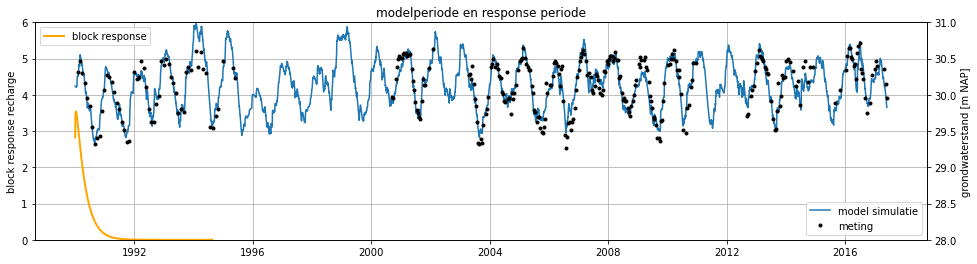

In [21]:
# get response function
sm = ml.stressmodels['recharge']
resp_func = sm.rfunc
fig, ax = plt.subplots(figsize=(16,4))
block_resp = resp_func.block(ml.get_parameters('recharge'), cutoff=0.9999999)

# plot response function
ax.plot(pd.date_range(ml.settings['tmin'], periods=len(block_resp)), block_resp, label='block response',
        color='orange', lw=2)
ax.grid()
ax.set_ylabel('block response recharge')
ax.set_ylim(0,6)
ax.set_title('modelperiode en response periode')
ax.legend(loc=2)

# plot model results
ax2 = ax.twinx()
ax2.plot(ml.simulate(), label='model simulatie')#, lw=0.2)
ax2.plot(oseries['1990':], marker='.', ls='', color='k', label='meting')
ax2.set_ylabel('grondwaterstand [m NAP]')
ax2.set_ylim(28,31)
ax2.legend(loc=4)

Het bepalen van het geheugen van de responsefunctie is minder vanzelfsprekend dan het in eerste instantie lijkt. De meeste responsefuncties in pastas zijn exponentiële functies met een horizontale asymptoot op y=0, de respons zal dus nooit gelijk zijn aan 0. Het is daarom niet mogelijk om het geheugen te bepalen door te kijken wanneer de response 0 is. Om deze reden wordt als maat voor het geheugen vaak de tijd genomen die het duurt voordat 95% van de response is uitgewerkt. Hieronder is dit visueel weergegeven.

geheugen (t95) -> 327 dagen


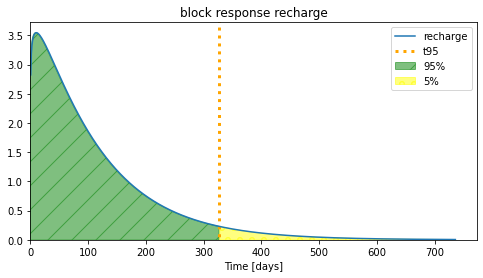

In [22]:
t95 = resp_func.get_tmax(ml.get_parameters('recharge'), cutoff=0.95)
print(f'geheugen (t95) -> {t95:.0f} dagen')

ax = ml.plots.block_response(figsize=(8,4))
ylim = ax.get_ylim()
ax.vlines(t95, -100, 100, ls=':', color='orange', label='t95', lw=3)

block_response = sm.rfunc.block(ml.get_parameters('recharge'))

ax.fill_between(range(len(block_response)), 0, block_response, 
                where=range(len(block_response))<t95,hatch='/',
                alpha=0.5, color='green', label='95%')

ax.fill_between(range(len(block_response)), 0, block_response, 
                where=range(len(block_response))>t95,hatch='o',
                alpha=0.5, color='yellow', label='5%')
ax.set_ylim(0, ylim[1])
ax.legend()
ax.set_title('block response recharge');

## Model diagnostics<a name="diagnostics"></a>



In [23]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.95,0.00,True
D'Agostino,Normality,34.11,0.00,True
Runs test,Autocorr.,-2.62,0.01,True
Stoffer-Toloi,Autocorr.,11.55,0.64,False


ValueError: Axis limits cannot be NaN or Inf

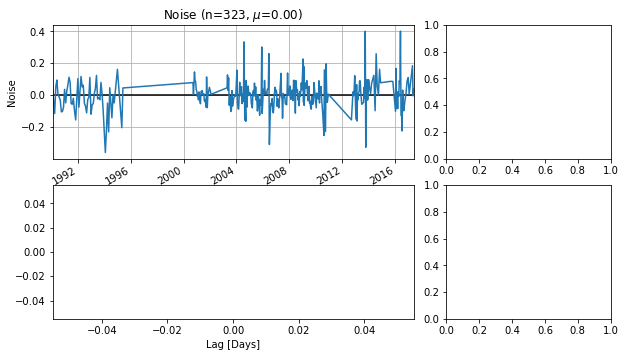

In [24]:
ml.plots.diagnostics()

## Fit report<a name="fitreport"></a>

Een groot deel van de hierboven besproken tools voor het beoordelen van een model worden automatisch getoond na het optimaliseren van een tijdreeksmodel met `ml.solve()`. Dit zogenaamde fit rapport geeft een overzicht van de resultaten van de optimalisatie. Het rapport bestaat uit 4 onderdelen:
- Algemene modelinstellingen (linksboven)
- Fit statistics (rechtsboven)
- Parameters (midden)
- Parameter correlations (onder)

Hieronder is een fit rapport weergegeven, daaronder is per onderdeel aangegeven welke resultaten worden getoond.

In [27]:
ml.solve(tmin='1990')

Fit report peilbuis 101          Fit Statistics
nfev     10                     EVP          87.18
nobs     323                    R2            0.87
noise    True                   RMSE          0.12
tmin     1990-01-01 00:00:00    AIC           6.79
tmax     2017-05-30 00:00:00    BIC          25.68
freq     D                      Obj           1.43
warmup   3650 days 00:00:00     ___               
solver   LeastSquares           Interpolated    No

Parameters (5 were optimized)
                optimal   stderr     initial  vary
recharge_A   481.302740   ±6.70%  210.475594  True
recharge_n     1.098185   ±3.06%    1.000000  True
recharge_a   102.875785  ±10.17%   10.000000  True
constant_d    29.887865   ±0.07%   30.150990  True
noise_alpha   45.201081  ±13.43%   20.000000  True

Parameter correlations |rho| > 0.5
recharge_A recharge_a  0.83
           constant_d -0.77
recharge_n recharge_a -0.79
recharge_a constant_d -0.64


**Algemene modelinstellingen**<br>
Hier worden een aantal instellingen en resultaten genoemd van het model. Dit zijn:
- `nfev`: Het aantal model simulaties dat is uitgevoerd door het optimalisatie-algoritme voordat de optimale parameters zijn gevonden. Wanneer de optimale oplossing niet gevonden kan worden en het maximaal aantal functie-evaluaties is berijkt wordt een waarschuwing gegeven.
- `nobs`: Het aantal metingen dat is gebruikt om de model simulatie te fitten op de metingen. In ons geval is dat het aantal metingen in `oseries1`.
- `noise`: parameters om aan te geven of het noise model is gebruikt bij de optimalisatie. Meer informatie over het noisemodel is hier te vinden [REFERENTIE]
- `tmin` and `tmax`: de start en de eindtijd van de metingen die gebruikt worden om het model te optimaliseren. Deze kunnen worden opgegeven in de `ml.solve()` functie. Standaard wordt de start- en eindtijd van de `oseries` gebruikt. In dit geval is aangegeven dat als starttijd 1 januari 1990 gebruikt moet worden.
- `freq`: de frequentie van het tijdreeksmodel. Standaard wordt een dagelijkse frequentie gebruikt [KLOPT DIT????]. Dit betekent dat de gesimuleerde en gemeten waarde op dagbasis worden vergeleken.
- `warmup`: De inlooptijd van het model. De grondwaterstanden op een bepaalde dag hangen af van de externe invloeden (stresses) over een bepaalde periode voor deze dag. We weten de lengte van deze periode niet. Standaard wordt een inlooptijd van 10 jaar min de starttijd `tmin` van het model gebruikt.
- `solver`: Het optimalisatie-algoritme dat wordt gebruikt om de gesimuleerde grondwaterstanden te fitten op de gemeten grondwaterstanden. Met de standaard instellingen wordt gebruikt gemaakt van de [`least_squares`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) solver uit de `scipy` package.

**Fit statistics**<br>
Rechtsboven in het model rapport
Deze statistieken geven informatie over de fit tussen gesimuleerde en gemeten grondwaterstanden. De volgende fit parameters worden getoond: 
- `EVP`: Explained variance ook wel bekend als de Nash Sutcliffe coëfficiënt. Een waarde van 100% betekent dat de gemodelleerde en gesimuleerde grondwaterstanden volledige overeenkomen. In de praktijk komt dat niet voor. Meestal wordt een fit hoger dan 60-80% acceptabel geacht om de modelresultaten verder te gebruiken.
- `R2`: the $R^2$ waarde wordt ook wel de determinatiecoëfficiënt genoemd. Een waarde van 1 staat voor een optimale fit.
- `RMSE`: de root mean squared error. Een waarde van 0 staat voor een optimale fit. 
- `AIC`: the Aikake Information Criterion.
- `BIC`: the Bayesan Information Criterion. 

**Parameters**<br>
Dit deel geeft de parameter waarde weer die zijn gevonden met het optimalisatie algoritme. Behalve de optimale waarde wordt ook de standaard deviatie en de initiële waarde weergegeven. In de laatste kolom is aangegeven of de parameter wel `vary=True` of niet `vary=False` is meegenomen in de optimalisatie.

**Parameter correlations**<br>
Deze sectie geeft de correlaties tussen de parameters aan. Alleen de correlaties met een absolute waarde hoger dan 0.5 zijn weergegeven. Wanneer twee parameters een correlatie dichtijb de 1 of -1 hebben betekent dit dat vergelijkbare modelresultaten bereikt kunnen worden met een verschillende set van de twee parameters.